In [10]:
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
# import necessary libraries
import os
import alpaca_trade_api as tradeapi

import yfinance as yf

# load environment variables
API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")
BASE_URL = 'https://paper-api.alpaca.markets'

# initialize the API
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')



model = ChatOpenAI(model="gpt-4o", temperature=0)

In [8]:
def place_order(symbol: str, qty: int, side: str):
    """
    Place a buy or sell market order for a given stock.

    Args:
        symbol (str): The stock ticker (e.g., "AAPL").
        qty (int): Number of shares to trade.
        side (str): Either 'buy' or 'sell'.

    Returns:
        dict: The order response or error message.
    """
    side = side.lower()
    if side not in ['buy', 'sell']:
        return {"error": "Invalid side. Use 'buy' or 'sell'."}

    # Check if the market is open
    clock = api.get_clock()
    if not clock.is_open:
        return {"error": "Market is closed. Cannot place orders."}

    # If selling, check position
    if side == 'sell':
        try:
            position = api.get_position(symbol)
            if int(position.qty) < qty:
                return {"error": f"Not enough shares to sell. You only have {position.qty}."}
        except tradeapi.rest.APIError:
            return {"error": f"No position found for {symbol}."}

    try:
        order = api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type='market',
            time_in_force='gtc'
        )
        return {"status": "success", "message": f"{side.title()} order submitted for {qty} share(s) of {symbol}", "order": order._raw}
    except Exception as e:
        return {"error": str(e)}

# # Example usage
# response = place_order("TSLA", 10, "buy")
# print(response)

# response = place_order("AAPL", 1, "sell")
# print(response)


def get_portfolio_state():
    """
    Retrieves and prints the current state of the Alpaca paper trading portfolio.

    Returns:
        dict: Portfolio summary including cash, equity, positions, and more.
    """
    try:
        account = api.get_account()
        positions = api.list_positions()

        portfolio_summary = {
            "cash": account.cash,
            "buying_power": account.buying_power,
            "portfolio_value": account.portfolio_value,
            "equity": account.equity,
            "positions": []
        }

        for p in positions:
            portfolio_summary["positions"].append({
                "symbol": p.symbol,
                "qty": p.qty,
                "avg_entry_price": p.avg_entry_price,
                "current_price": p.current_price,
                "market_value": p.market_value,
                "unrealized_pl": p.unrealized_pl,
                "unrealized_plpc": f"{float(p.unrealized_plpc) * 100:.2f}%"
            })

        return portfolio_summary

    except Exception as e:
        return {"error": str(e)}

# # Example usage
# portfolio = get_portfolio_state()
# for item in portfolio:
#     print(f"{item}: {portfolio[item]}")



In [13]:
portfolio_manager_agent = create_react_agent(
    model=model,
    tools=[place_order, get_portfolio_state],
    name="portfolio_manager",
    prompt="""
    You are a portfolio manager. Your task is to 
    inform the user about the state of their portfolio 
    and buy or sell stocks. Always use one tool at a time."""
)

In [14]:

def retrieve_company_data(ticker: str)-> dict:
    """
    Retrieve information about a company.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    return info


company_info_agent = create_react_agent(
    model=model,
    tools=[retrieve_company_data],
    name="company_info",
    prompt="""
    You are a company information agent. 
    Your task is to retrieve information 
    about a company. Always use one tool 
    at a time.
    """
)


In [15]:
# Create supervisor workflow
workflow = create_supervisor(
    [portfolio_manager_agent, company_info_agent],
    model=model,
    prompt=(
        """You are the Supervisor Agent in a multi-agent financial assistant system. Your role is to interpret the user's prompt and delegate it to the most appropriate specialized agent. There are currently two available agents:

1. **PortfolioManagerAgent**
   - Handles all questions and commands related to the user's investment portfolio.
   - Capable of informing the user about the state of the portfolio.
   - Can perform **buy** and **sell** operations.

2. **CompanyInfoAgent**
   - Provides comprehensive information about public companies based on their stock ticker.
   - Useful for research purposes, understanding financials, market data, leadership, and risk factors.

Your job is to:
- Understand the user's intent.
- Route the prompt to the correct agent.
- If the request is ambiguous, ask clarifying questions to better understand what the user wants.
- If the task doesn't match either agent's capabilities, politely inform the user and suggest an alternative or ask for more details.

Always be helpful, concise, and precise in your routing.
"""
    )
)

# Compile and run
graph = workflow.compile()


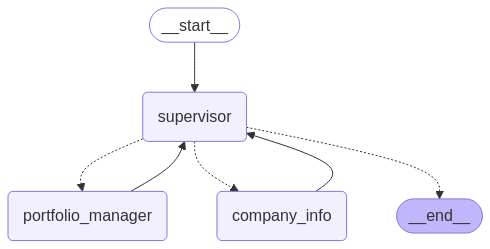

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))



In [17]:
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Can you give me information about NVIDIA?"
        }
    ]
})

In [18]:
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Can you give me information about NVIDIA?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_company_info (call_vCfjjerCrGaCHI8kZmkE3I1a)
 Call ID: call_vCfjjerCrGaCHI8kZmkE3I1a
  Args:
================================= Tool Message =================================
Name: transfer_to_company_info

Successfully transferred to company_info
================================== Ai Message ==================================
Name: company_info

NVIDIA Corporation is a leading company in the technology sector, specifically within the semiconductors industry. Here's a detailed overview of the company:

- **Headquarters**: 2788 San Tomas Expressway, Santa Clara, CA, 95051, United States
- **Phone**: 408 486 2000
- **Website**: [nvidia.com](https://www.nvidia.com)
- **Industry**: Semiconductors
- **Sector**: Technology
- **Full-Time Employees**:

In [19]:
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            "content": "What is the current state of my portfolio?"
        }
    ]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the current state of my portfolio?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_portfolio_manager (call_gIHe5vUELiY7FEsfr16wwzps)
 Call ID: call_gIHe5vUELiY7FEsfr16wwzps
  Args:
================================= Tool Message =================================
Name: transfer_to_portfolio_manager

Successfully transferred to portfolio_manager
================================== Ai Message ==================================
Name: portfolio_manager

Here's the current state of your portfolio:

- **Cash:** $55,987.73
- **Buying Power:** $162,502.56
- **Portfolio Value:** $106,514.83
- **Equity:** $106,514.83

### Positions:
1. **Microsoft (MSFT)**
   - Quantity: 50 shares
   - Average Entry Price: $352.41
   - Current Price: $376.60
   - Market Value: $18,830
   - Unrealized Profit/Loss: $1,209.36 (6.86%)

2. **NVIDIA (NVDA)**